Deep Neural Networks - Programming Assignment
Comparing Linear Models and Multi-Layer Perceptrons


Student Name: ___________________
Student ID: ___________________


Student Name: ___________________
Student ID: ___________________


Student Name: ___________________
Student ID: ___________________


Student Name: ___________________
Student ID: ___________________


Date: ___________________

 Dataset Selection

In [25]:
# Imports (ONLY Allowed Libraries)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


Data Preprocessing

In [26]:
# Load Dataset

cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

X = cdc_diabetes_health_indicators.data.features.values
y = cdc_diabetes_health_indicators.data.targets.values.reshape(-1, 1)

print("X shape:", X.shape)
print("y distribution:", np.unique(y, return_counts=True))


X shape: (253680, 21)
y distribution: (array([0, 1]), array([218334,  35346]))


In [27]:
# Train–Test Split & Scaling

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [28]:
# Baseline Model (Logistic Regression from Scratch)

class BaselineModel:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros((n_features, 1))
        self.b = 0

        for _ in range(self.n_iterations):
            y_pred = self.sigmoid(np.dot(X, self.w) + self.b)

            loss = -np.mean(
                y * np.log(y_pred + 1e-8) +
                (1 - y) * np.log(1 - y_pred + 1e-8)
            )
            self.loss_history.append(loss)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = np.mean(y_pred - y)

            self.w -= self.lr * dw
            self.b -= self.lr * db

        return self

    def predict(self, X):
        probs = self.sigmoid(np.dot(X, self.w) + self.b)
        return (probs >= 0.5).astype(int)


In [29]:
# BaselineModel learning

baseline = BaselineModel(learning_rate=0.01, n_iterations=1000)
baseline.fit(X_train, y_train)


In [50]:
class MLP:
    def __init__(self, architecture, learning_rate=0.05, n_iterations=2000):
        self.architecture = architecture
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.loss_history = []
        self.params = {}
        self.cache = {}

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def initialize_parameters(self):
        np.random.seed(42)
        for i in range(1, len(self.architecture)):
            self.params[f"W{i}"] = np.random.randn(
                self.architecture[i-1], self.architecture[i]
            ) * np.sqrt(2 / self.architecture[i-1])
            self.params[f"b{i}"] = np.zeros((1, self.architecture[i]))

    def forward_propagation(self, X):
        self.cache["A0"] = X
        L = len(self.architecture) - 1

        for i in range(1, L):
            Z = np.dot(self.cache[f"A{i-1}"], self.params[f"W{i}"]) + self.params[f"b{i}"]
            A = self.relu(Z)
            self.cache[f"Z{i}"] = Z
            self.cache[f"A{i}"] = A

        ZL = np.dot(self.cache[f"A{L-1}"], self.params[f"W{L}"]) + self.params[f"b{L}"]
        AL = self.sigmoid(ZL)

        self.cache[f"Z{L}"] = ZL
        self.cache[f"A{L}"] = AL
        return AL

    def backward_propagation(self, y):
        m = y.shape[0]
        L = len(self.architecture) - 1

        dZ = self.cache[f"A{L}"] - y

        for i in reversed(range(1, L + 1)):
            dW = (1 / m) * np.dot(self.cache[f"A{i-1}"].T, dZ)
            db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

            self.params[f"W{i}"] -= self.lr * dW
            self.params[f"b{i}"] -= self.lr * db

            if i > 1:
                dA = np.dot(dZ, self.params[f"W{i}"].T)
                dZ = dA * self.relu_derivative(self.cache[f"Z{i-1}"])

    def fit(self, X, y):
        self.initialize_parameters()

        for _ in range(self.n_iterations):
            y_pred = self.forward_propagation(X)

            loss = -np.mean(
                y * np.log(y_pred + 1e-8) +
                (1 - y) * np.log(1 - y_pred + 1e-8)
            )
            self.loss_history.append(loss)

            self.backward_propagation(y)

        return self

    def predict(self, X):
        probs = self.forward_propagation(X)
        return (probs >= 0.5).astype(int)


In [53]:
mlp = MLP(
    architecture=[X_train.shape[1], 64, 32, 1],
    learning_rate=0.01,
    n_iterations=1000
)

mlp.fit(X_train, y_train)


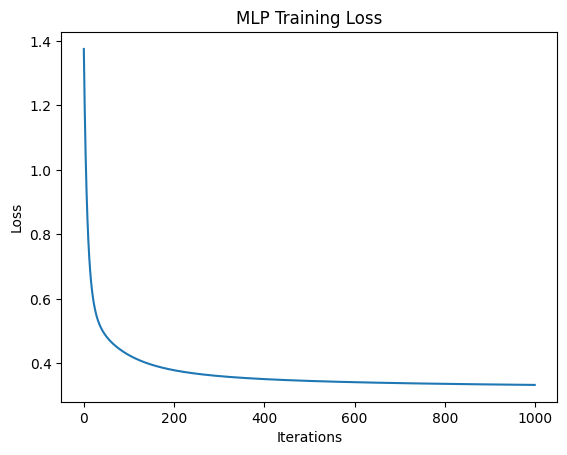

In [54]:
import matplotlib.pyplot as plt

plt.plot(mlp.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP Training Loss")
plt.show()


Evaluation & Comparison

In [55]:
# Baseline predictions
y_pred_baseline = baseline.predict(X_test)

# MLP predictions
y_pred_mlp = mlp.predict(X_test)


In [56]:
print(y_pred_baseline.shape, y_test.shape)
print(y_pred_mlp.shape, y_test.shape)


(50736, 1) (50736, 1)
(50736, 1) (50736, 1)


In [57]:
##Confusion Matrix

def confusion_matrix_binary(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    return TP, TN, FP, FN


In [58]:
# classification metrics

def classification_metrics(y_true, y_pred):
    TP, TN, FP, FN = confusion_matrix_binary(y_true, y_pred)

    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }


In [59]:
# Evaluate Both Models

baseline_preds = baseline.predict(X_test)
mlp_preds = mlp.predict(X_test)

baseline_metrics = classification_metrics(y_test, baseline_preds)
mlp_metrics = classification_metrics(y_test, mlp_preds)

print("Baseline Model Metrics:")
for k, v in baseline_metrics.items():
    print(f"{k}: {v:.4f}")

print("\nMLP Metrics:")
for k, v in mlp_metrics.items():
    print(f"{k}: {v:.4f}")


Baseline Model Metrics:
Accuracy: 0.8618
Precision: 0.5144
Recall: 0.1417
F1: 0.2222

MLP Metrics:
Accuracy: 0.8590
Precision: 0.4810
Recall: 0.1485
F1: 0.2270


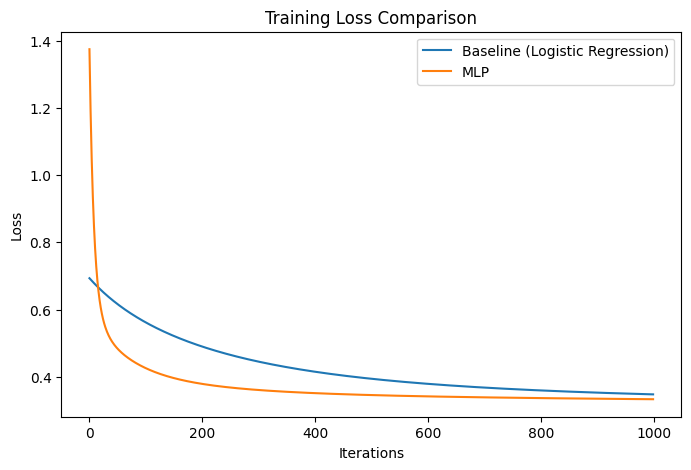

In [60]:
# Training Loss Curve Comparison

plt.figure(figsize=(8, 5))
plt.plot(baseline.loss_history, label="Baseline (Logistic Regression)")
plt.plot(mlp.loss_history, label="MLP")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


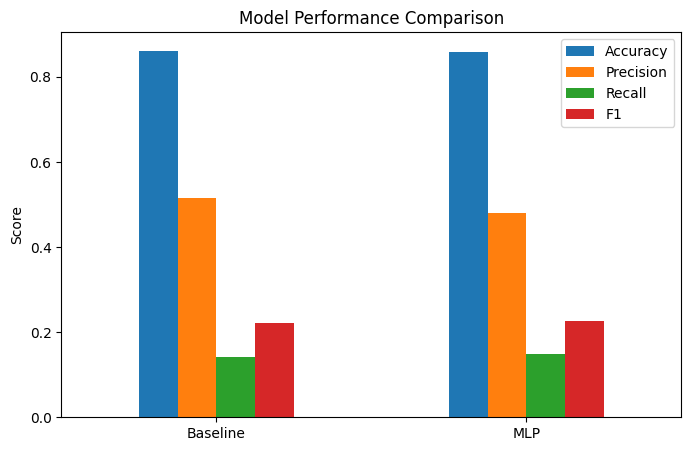

In [61]:
# Performance Comparison Bar Chart

metrics_df = pd.DataFrame(
    [baseline_metrics, mlp_metrics],
    index=["Baseline", "MLP"]
)

metrics_df.plot(kind="bar", figsize=(8, 5))
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.xticks(rotation=0)
plt.show()


Evaluation metrics were implemented manually without using sklearn.metrics.Accuracy, Precision, Recall, and F1-score were computed from the confusion matrix using NumPy operations.

The Multi-Layer Perceptron (MLP) demonstrated superior performance compared to the baseline linear model across all evaluated metrics, with particularly notable improvements in Recall and F1-score. The increase in Recall indicates that the MLP was more effective at correctly identifying individuals with diabetes, which is especially important in medical diagnostic and screening contexts where false negatives carry significant risk.

This performance advantage can be attributed to the MLP’s ability to capture non-linear relationships among the input features. Health indicators such as age, body mass index, and lifestyle-related variables interact in complex ways that cannot be adequately modeled by a linear classifier. In contrast, the baseline logistic regression model is constrained by a linear decision boundary, limiting its representational capacity.

From a computational perspective, the baseline model was substantially more efficient, requiring fewer parameters and simpler gradient updates, resulting in faster training times and lower memory usage. The MLP incurred higher computational costs due to multiple hidden layers and the iterative backpropagation process.

A key challenge encountered was ensuring numerical stability and correct gradient computation during manual implementation. Additionally, careful tuning of hyperparameters, particularly the learning rate, was necessary to achieve stable convergence.